## Генерируем данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
X, y = make_moons(n_samples=1_000, random_state=0, noise=0.3)

df = pd.DataFrame({
    'feat1': X[:, 0],
    'feat2': X[:, 1],
    'feat3': np.random.rand(X.shape[0]),
    'feat4': np.random.rand(X.shape[0]),
    'target': y
})

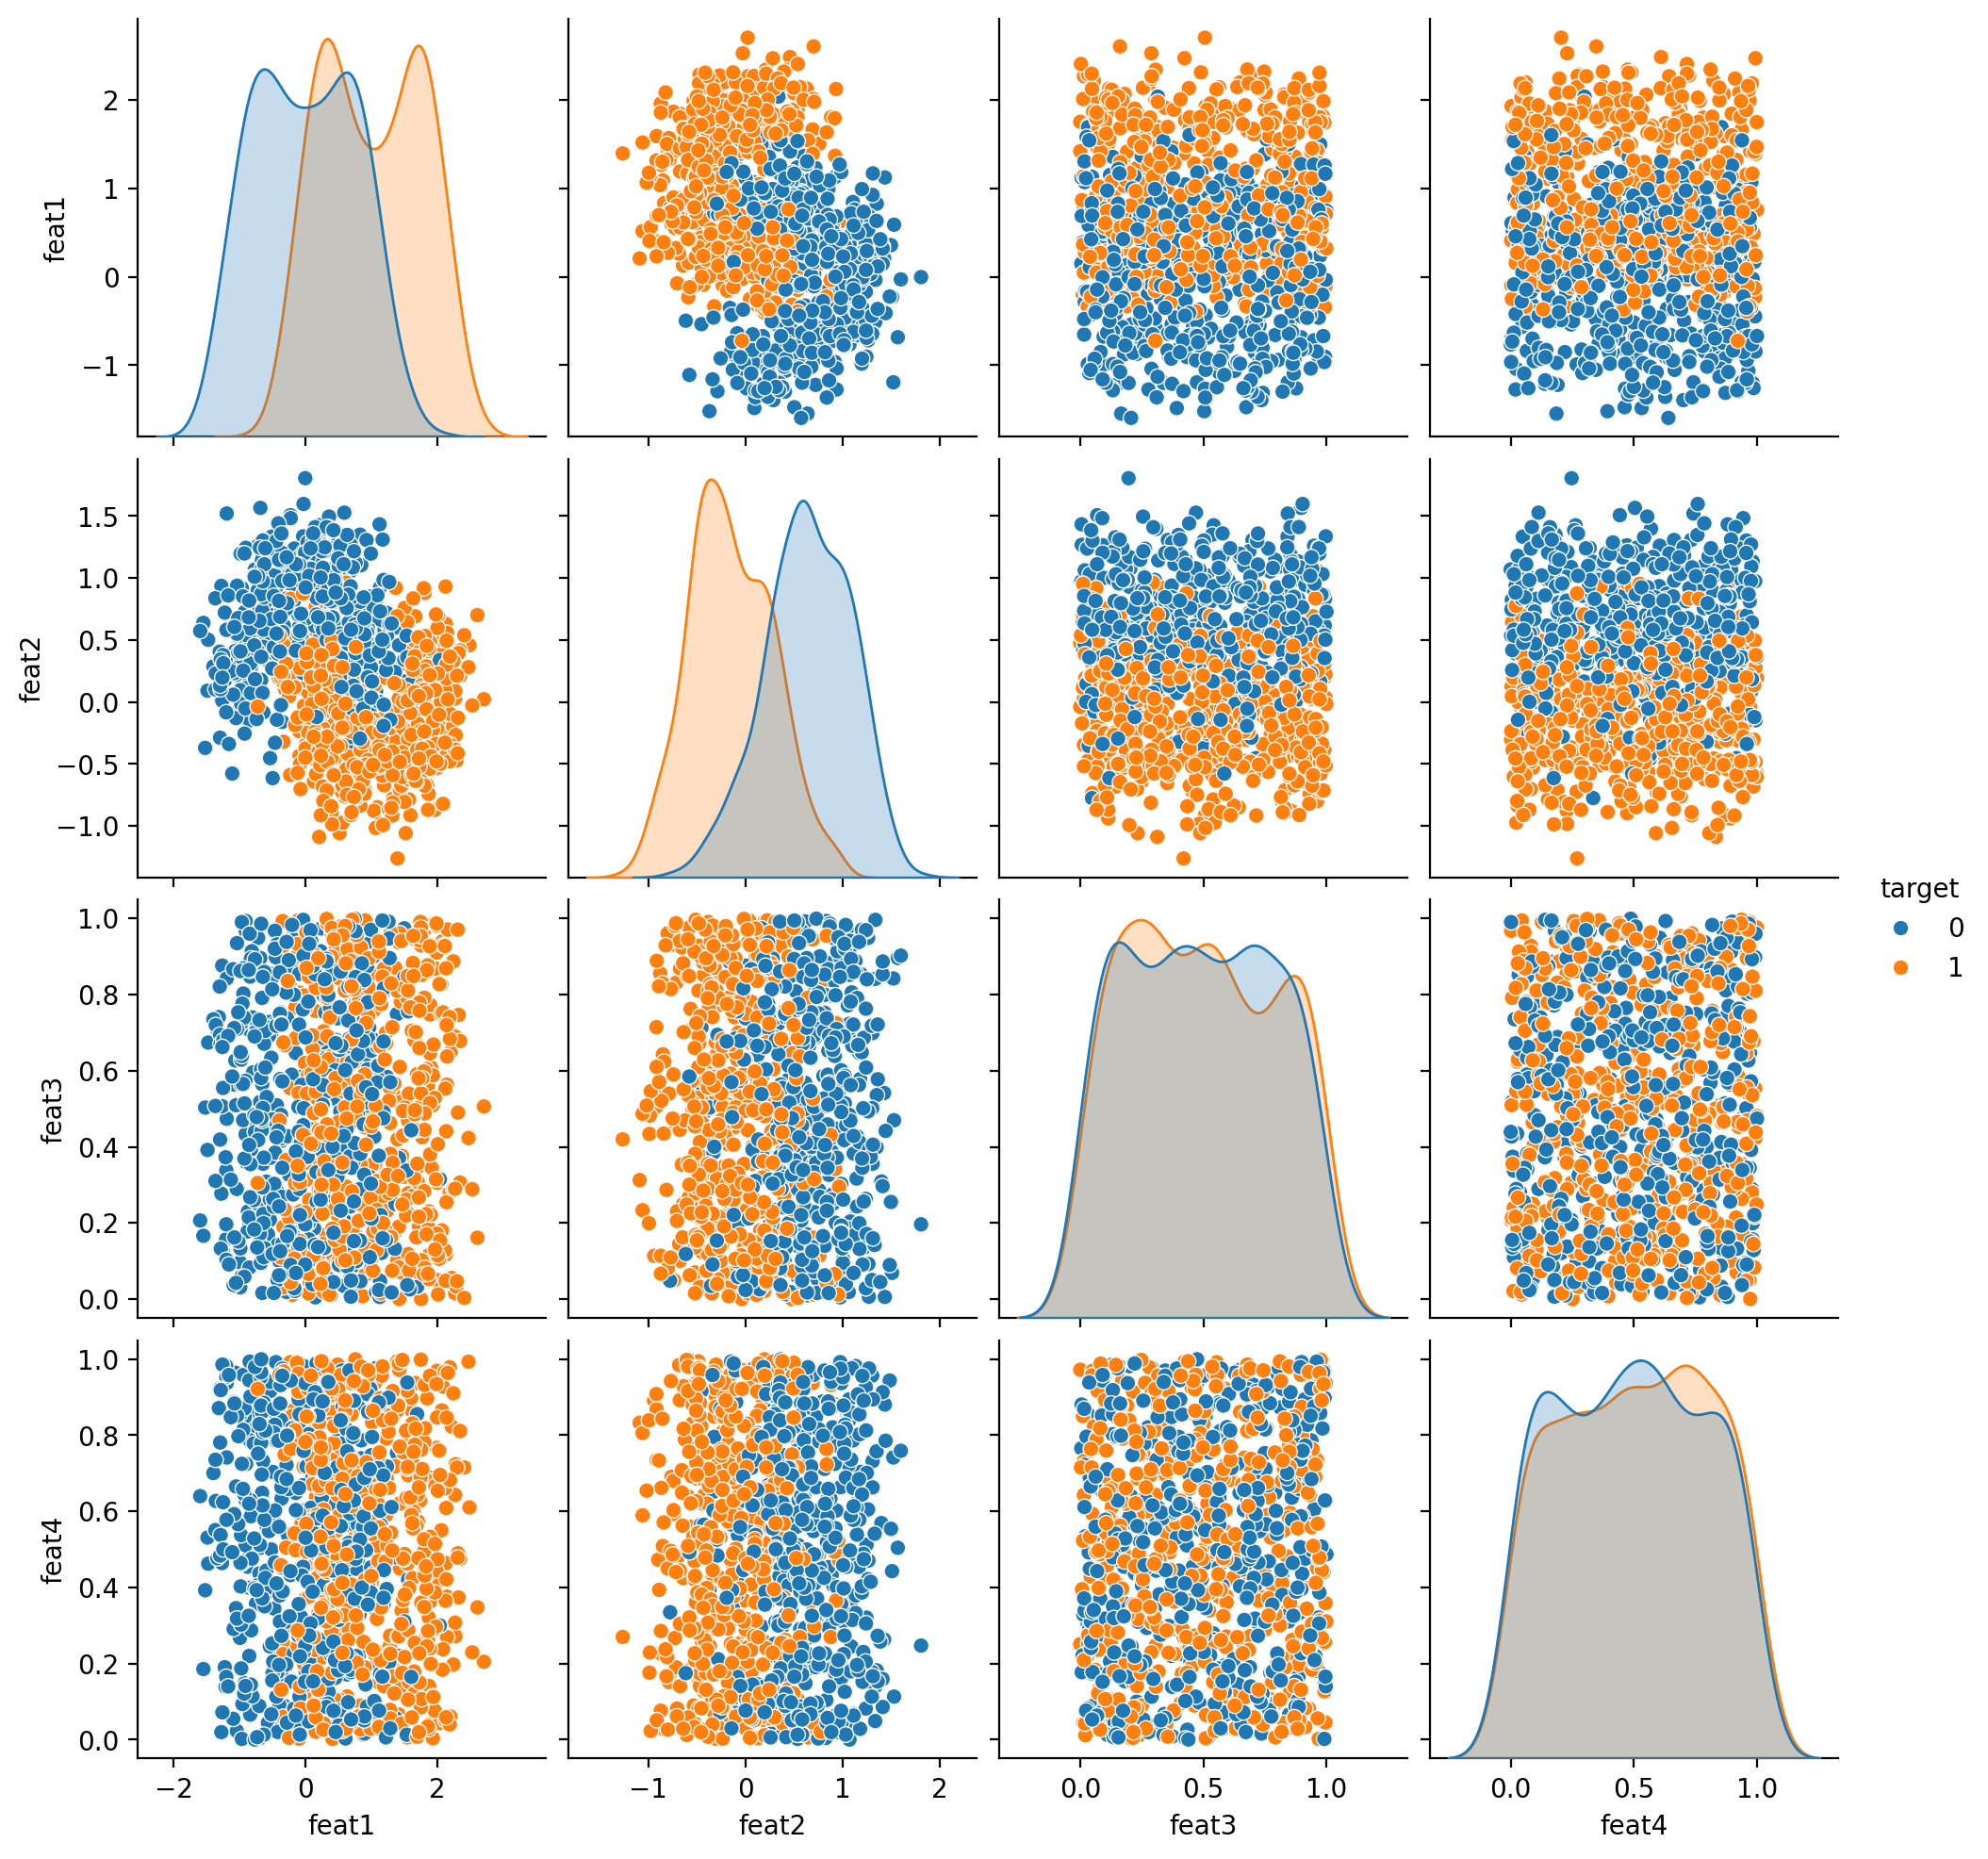

In [3]:
sns.pairplot(df, hue='target')

In [4]:
df.head()

,feat1,feat2,feat3,feat4,target
0,2.129573,0.629904,0.117274,0.464063,1
1,1.888882,0.146257,0.747881,0.436482,1
2,-0.190357,0.383993,0.181585,0.153308,0
3,-0.404416,0.195282,0.407148,0.095020,1
4,0.373012,-0.429716,0.851768,0.126965,1


## Инициализация PyCaret и Spark

In [5]:
from pycaret.classification import setup, compare_models, tune_model, evaluate_model, create_model

from pyspark.sql import SparkSession
from pycaret.parallel import FugueBackend

In [6]:
spark = (
    SparkSession.
    builder.
    appName('pycaret').
    config('spark.driver.memory', '2g').
    config('spark.executor.memory', '2g').
    getOrCreate()
)
    
s = setup(
  data=df, 
  target='target',
  n_jobs=1
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/18 18:31:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,Description,Value
0,Session id,8374
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 5)"
4,Transformed data shape,"(1000, 5)"
5,Transformed train set shape,"(700, 5)"
6,Transformed test set shape,"(300, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


## Сравнение доступных алгоритмов

In [7]:
%%time
best = compare_models(
  parallel=FugueBackend(spark)  
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8957,0.9598,0.8971,0.8964,0.8952,0.7914,0.7942,0.281
rf,Random Forest Classifier,0.8943,0.9534,0.9086,0.8856,0.8952,0.7886,0.7921,0.254
lightgbm,Light Gradient Boosting Machine,0.8929,0.9536,0.9000,0.8889,0.8932,0.7857,0.7880,0.090
ada,Ada Boost Classifier,0.8914,0.9539,0.8886,0.8948,0.8903,0.7829,0.7853,0.140
knn,K Neighbors Classifier,0.8871,0.9304,0.9086,0.8728,0.8886,0.7743,0.7784,0.066
et,Extra Trees Classifier,0.8857,0.9533,0.9114,0.8681,0.8882,0.7714,0.7745,0.201
dt,Decision Tree Classifier,0.8471,0.8471,0.8657,0.8392,0.8496,0.6943,0.6996,0.033
ridge,Ridge Classifier,0.8400,0.9248,0.8371,0.8424,0.8383,0.6800,0.6828,0.044
lda,Linear Discriminant Analysis,0.8400,0.9247,0.8371,0.8424,0.8383,0.6800,0.6828,0.043
lr,Logistic Regression,0.8386,0.9247,0.8314,0.8436,0.8359,0.6771,0.6801,0.087


CPU times: user 298 ms, sys: 83.1 ms, total: 381 ms
Wall time: 18.4 s


## Подбор гиперпараметров

In [8]:
model = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8857,0.9376,0.8857,0.8857,0.8857,0.7714,0.7714
1,0.8857,0.9600,0.8286,0.9355,0.8788,0.7714,0.7765
2,0.9143,0.9629,0.9143,0.9143,0.9143,0.8286,0.8286
3,0.8857,0.9527,0.9429,0.8462,0.8919,0.7714,0.7765
4,0.9286,0.9665,0.8857,0.9688,0.9254,0.8571,0.8603
5,0.9286,0.9731,0.9429,0.9167,0.9296,0.8571,0.8575
6,0.9429,0.9771,0.9714,0.9189,0.9444,0.8857,0.8872
7,0.8714,0.9437,0.9143,0.8421,0.8767,0.7429,0.7456
8,0.8429,0.9527,0.8857,0.8158,0.8493,0.6857,0.6882


In [9]:
tuned_best = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9000,0.9420,0.9143,0.8889,0.9014,0.8000,0.8003
1,0.9286,0.9763,0.9143,0.9412,0.9275,0.8571,0.8575
2,0.9000,0.9567,0.9143,0.8889,0.9014,0.8000,0.8003
3,0.9143,0.9580,0.9429,0.8919,0.9167,0.8286,0.8299
4,0.9000,0.9690,0.8571,0.9375,0.8955,0.8000,0.8030
5,0.9714,0.9902,0.9714,0.9714,0.9714,0.9429,0.9429
6,0.9286,0.9820,0.9429,0.9167,0.9296,0.8571,0.8575
7,0.8857,0.9690,0.9429,0.8462,0.8919,0.7714,0.7765
8,0.8429,0.9453,0.8571,0.8333,0.8451,0.6857,0.6860


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [10]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Прибиваем spark-сессию

In [8]:
spark.stop()